In [27]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from utils import DatabaseEngine

In [28]:
db_engine = DatabaseEngine()
engine = db_engine.create()
clean_df = pd.read_sql_table("clean_xdr_data", con=engine)

Successfully connected to the PostgreSQL "telecom" database


In [29]:
data_df = pd.read_csv('../data/user_info.csv')
data_df.columns = ['MSISDN/Number_data' if col=='MSISDN/Number' else col for col in data_df.columns]

In [30]:
df = pd.concat([clean_df, data_df], axis=1)

## User Engagement Analysis

In [31]:
df['Total Traffic'] = df['Total Download Data'] + df['Total Upload Data']
engagement_metrics = ['Number of Sessions', 'Total Session Duration', 'Total Traffic']

for metric in engagement_metrics:
    top_10_customers = df.nlargest(10, metric)[['MSISDN/Number', metric]]
    print(f"Top 10 customers for {metric}:")
    print(top_10_customers.to_string(index=False))
    print("\n")

Top 10 customers for Number of Sessions:
MSISDN/Number  Number of Sessions
33662221880.0                18.0
33627488961.0                17.0
33782153624.0                17.0
33659864193.0                16.0
33662873199.0                15.0
33646822037.0                15.0
33665620160.0                13.0
33669596538.0                12.0
33699748122.0                12.0
33658501067.0                12.0


Top 10 customers for Total Session Duration:
MSISDN/Number  Total Session Duration
33782153624.0              18553754.0
33627488961.0               9966898.0
33646822037.0               9279434.0
33662221880.0               8791927.0
33665620160.0               8744914.0
33615304826.0               6614270.0
33619864766.0               6288730.0
33669596538.0               6287761.0
33658111684.0               5649882.0
33676748802.0               5321667.0


Top 10 customers for Total Traffic:
MSISDN/Number  Total Traffic
33627488961.0   8846226494.0
33646822037.0   85147739

In [32]:
# Function to handle outliers
def replace_with_mean(df, column):
    mean = df[column].mean()
    std = df[column].std()
    is_outlier = (df[column] - mean).abs() > 3*std
    df.loc[is_outlier, column] = mean
    return df

#### K-means clustering For User Engagement Analysis

In [33]:
data_df['Total Traffic'] = data_df['Total Download Data'] + data_df['Total Upload Data']

engagement_metrics = ['Number of Sessions', 'Total Session Duration', 'Total Traffic']
for metric in engagement_metrics:
    data_df = replace_with_mean(data_df, metric)

# Normalize the engagement metrics
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_df[engagement_metrics])

# Run k-means clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
clusters = kmeans.fit_predict(normalized_data)

In [34]:
# Add the cluster labels to the DataFrame
data_df['Engagement Cluster'] = clusters

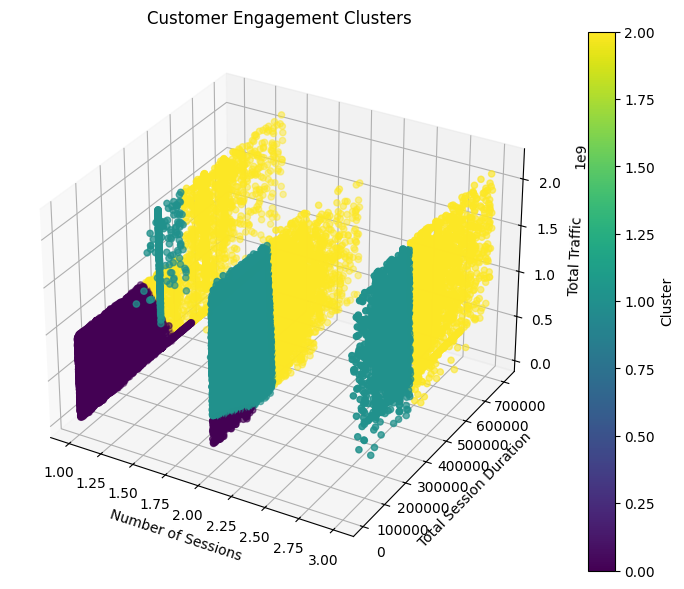

In [35]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_df['Number of Sessions'], 
                     data_df['Total Session Duration'], 
                     data_df['Total Traffic'], 
                     c=clusters, 
                     cmap='viridis')

ax.set_title('Customer Engagement Clusters')
ax.set_xlabel('Number of Sessions')
ax.set_ylabel('Total Session Duration')
ax.set_zlabel('Total Traffic')

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()

#### min, max, avg, and non-normalized metrics for each cluster

In [36]:
cluster_metrics = data_df.groupby('Engagement Cluster')[engagement_metrics].agg(['min', 'max', 'mean', 'sum'])
pd.DataFrame(cluster_metrics)

Number of Sessions                               \
                                  min  max      mean           sum   
Engagement Cluster                                                   
0                            1.000000  2.0  1.007487  78475.160571   
1                            1.393792  3.0  2.116836  43473.469202   
2                            1.000000  3.0  1.956044  16483.586865   

                   Total Session Duration                           \
                                      min       max           mean   
Engagement Cluster                                                   
0                                  7142.0  411373.0   99798.517335   
1                                 18235.0  311044.0  159029.096845   
2                                251602.0  705046.0  401466.863653   

                                 Total Traffic                              \
                             sum           min           max          mean   
Engagement Cluster                                                           
0                   7.773506e+09    33249009.0  9.507607e+08  4.965486e+08   
1                   3.265981e+09   166910132.0  2.163818e+09  1.060407e+09   
2                   3.383161e+09    57140040.0  2.163675e+09  1.114732e+09   

                                  
                             sum  
Engagement Cluster                
0                   3.867717e+13  
1                   2.177758e+13  
2                   9.393849e+12

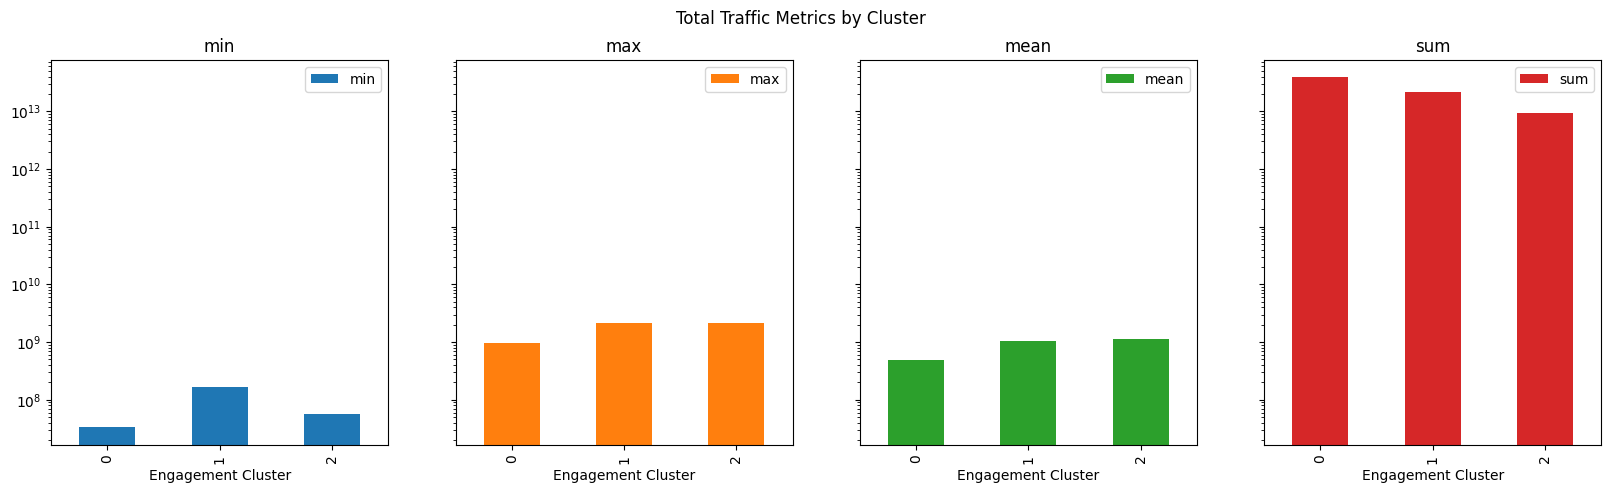

In [37]:
cluster_metrics['Total Traffic'].plot(kind='bar', subplots=True, layout=(1,4), sharey=True, figsize=(20,5), title='Total Traffic Metrics by Cluster')
plt.yscale('log')
plt.show()

In [56]:
applications = {
    # 'Social Media': ['Social Media Download Data', 'Social Media Upload Data'],
    'Google': ['Google Download Data', 'Google Upload Data'],
    'Email': ['Email Download Data', 'Email Upload Data'],
    'Youtube': ['Youtube Download Data', 'Youtube Upload Data'],
    'Netflix': ['Netflix Download Data', 'Netflix Upload Data'],
    # 'Gaming': ['Gaming Download Data', 'Gaming Upload Data'],
    # 'Other': ['Other Download Data', 'Other Upload Data']
}

for app, (dl, ul) in applications.items():
    data_df[app + ' Total Data'] = data_df[dl] + data_df[ul]

# Group by user and sum the total traffic for each application
user_total_traffic = data_df.groupby('MSISDN/Number_data')[[app + ' Total Data' for app in applications]].sum()

# For each application, sort the users by total traffic and select the top 10
for app in applications:
    top_users = user_total_traffic[app + ' Total Data'].nlargest(10)
    user_total_traffic.index = user_total_traffic.index.astype(int)
    print(f"Top 10 users for {app}:")
    print(pd.DataFrame(top_users).to_string())
    print("\n")

Top 10 users for Google:
                    Google Total Data
MSISDN/Number_data                   
3.362632e+10              152191852.0
3.362578e+10              142307915.0
3.361489e+10              127973787.0
3.376054e+10              123223099.0
3.365973e+10              116516345.0
3.378632e+10              110254484.0
3.367588e+10              109860502.0
3.366716e+10              105032696.0
3.376127e+10               97089988.0
3.369876e+10               91935151.0


Top 10 users for Email:
                    Email Total Data
MSISDN/Number_data                  
33626320676               42418782.0
33614892860               40788634.0
33625779332               40633966.0
33786323068               36310123.0
33659725664               35999792.0
33760536639               33693767.0
33675877202               31514421.0
33665460546               30417885.0
33667163239               30335796.0
33698792269               29059042.0


Top 10 users for Youtube:
                    Y

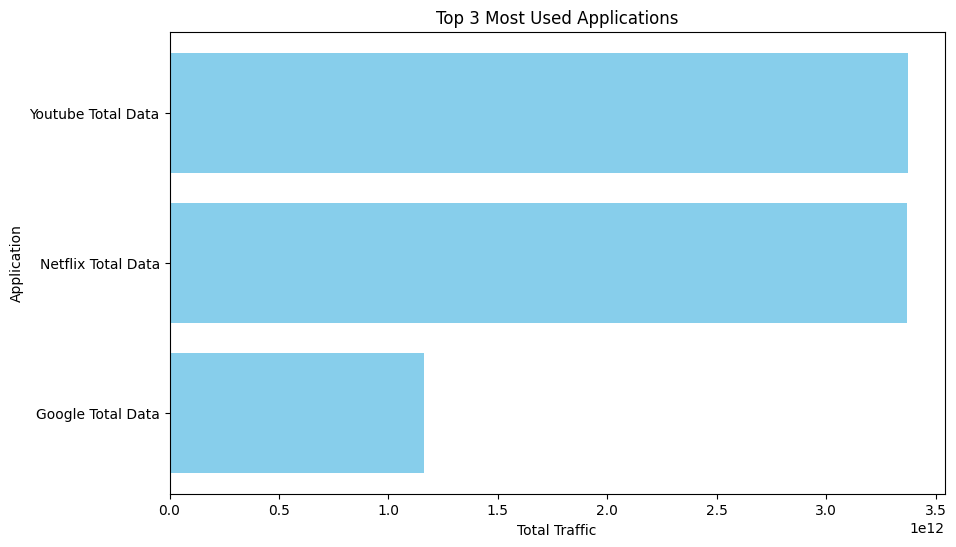

In [58]:
total_traffic_per_app = data_df[[app + ' Total Data' for app in applications]].sum()
top_3_apps = total_traffic_per_app.nlargest(3)

plt.figure(figsize=(10, 6))
plt.barh(top_3_apps.index, top_3_apps.values, color='skyblue')
plt.xlabel('Total Traffic')
plt.ylabel('Application')
plt.title('Top 3 Most Used Applications')
plt.gca().invert_yaxis()  # Invert y-axis to have the application with the highest traffic at the top
plt.show()